<a href="https://colab.research.google.com/github/aknip/image_generation/blob/main/demo_fusion_highres_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DemoFusion - This AI image generator can create pictures up to 16x higher resolution than Stable Diffusion

DemoFusion is completely open source and can be run on a basic gaming computer without any specialized hardware.

https://ruoyidu.github.io/demofusion/demofusion.html

Demo Notebook (this one):
https://github.com/PRIS-CV/DemoFusion/blob/main/demo.ipynb



# Generate with DemoFusion

- `view_batch_size` (`int`, defaults to 16):
  The batch size for multiple denoising paths. Typically, a larger batch size can result in higher efficiency but comes with increased GPU memory requirements.

- `stride` (`int`, defaults to 64):
  The stride of moving local patches. A smaller stride is better for alleviating seam issues, but it also introduces additional computational overhead and inference time.

- `cosine_scale_1` (`float`, defaults to 3):
  Control the strength of skip-residual. For specific impacts, please refer to Appendix C in the DemoFusion paper.

- `cosine_scale_2` (`float`, defaults to 1):
  Control the strength of dilated sampling. For specific impacts, please refer to Appendix C in the DemoFusion paper.

- `cosine_scale_3` (`float`, defaults to 1):
  Control the strength of the Gaussian filter. For specific impacts, please refer to Appendix C in the DemoFusion paper.

- `sigma` (`float`, defaults to 1):
  The standard value of the Gaussian filter. Larger sigma promotes the global guidance of dilated sampling, but has the potential of over-smoothing.

- `multi_decoder` (`bool`, defaults to True):
  Determine whether to use a tiled decoder. Generally, when the resolution exceeds 3072x3072, a tiled decoder becomes necessary.

- `show_image` (`bool`, defaults to False):
  Determine whether to show intermediate results during generation.

In [ ]:
!pip install diffusers accelerate

In [2]:
!python -c "from accelerate.utils import write_basic_config; write_basic_config(mixed_precision='fp16')"
# see https://huggingface.co/docs/accelerate/basic_tutorials/install

In [ ]:
# import statement in the main code cell does not work....
# Workaround:
# The following code cell is copy-pasted from the file pipeline_demofusion_sdxl.py
# https://github.com/PRIS-CV/DemoFusion/blob/main/pipeline_demofusion_sdxl.py


In [4]:
# @title
# Copyright 2023 The HuggingFace Team. All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import inspect
import os
from typing import Any, Callable, Dict, List, Optional, Tuple, Union
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
import numpy as np
import random
import warnings
from transformers import CLIPTextModel, CLIPTextModelWithProjection, CLIPTokenizer

from diffusers.image_processor import VaeImageProcessor
from diffusers.loaders import (
    FromSingleFileMixin,
    LoraLoaderMixin,
    TextualInversionLoaderMixin,
)
from diffusers.models import AutoencoderKL, UNet2DConditionModel
from diffusers.models.attention_processor import (
    AttnProcessor2_0,
    LoRAAttnProcessor2_0,
    LoRAXFormersAttnProcessor,
    XFormersAttnProcessor,
)
from diffusers.models.lora import adjust_lora_scale_text_encoder
from diffusers.schedulers import KarrasDiffusionSchedulers
from diffusers.utils import (
    is_accelerate_available,
    is_accelerate_version,
    is_invisible_watermark_available,
    logging,
    replace_example_docstring,
)
from diffusers.utils.torch_utils import randn_tensor
from diffusers.pipelines.pipeline_utils import DiffusionPipeline
from diffusers.pipelines.stable_diffusion_xl import StableDiffusionXLPipelineOutput


if is_invisible_watermark_available():
    from .watermark import StableDiffusionXLWatermarker


logger = logging.get_logger(__name__)  # pylint: disable=invalid-name

EXAMPLE_DOC_STRING = """
    Examples:
        ```py
        >>> import torch
        >>> from diffusers import StableDiffusionXLPipeline

        >>> pipe = StableDiffusionXLPipeline.from_pretrained(
        ...     "stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16
        ... )
        >>> pipe = pipe.to("cuda")

        >>> prompt = "a photo of an astronaut riding a horse on mars"
        >>> image = pipe(prompt).images[0]
        ```
"""

def gaussian_kernel(kernel_size=3, sigma=1.0, channels=3):
    x_coord = torch.arange(kernel_size)
    gaussian_1d = torch.exp(-(x_coord - (kernel_size - 1) / 2) ** 2 / (2 * sigma ** 2))
    gaussian_1d = gaussian_1d / gaussian_1d.sum()
    gaussian_2d = gaussian_1d[:, None] * gaussian_1d[None, :]
    kernel = gaussian_2d[None, None, :, :].repeat(channels, 1, 1, 1)

    return kernel

def gaussian_filter(latents, kernel_size=3, sigma=1.0):
    channels = latents.shape[1]
    kernel = gaussian_kernel(kernel_size, sigma, channels).to(latents.device, latents.dtype)
    blurred_latents = F.conv2d(latents, kernel, padding=kernel_size//2, groups=channels)

    return blurred_latents

# Copied from diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.rescale_noise_cfg
def rescale_noise_cfg(noise_cfg, noise_pred_text, guidance_rescale=0.0):
    """
    Rescale `noise_cfg` according to `guidance_rescale`. Based on findings of [Common Diffusion Noise Schedules and
    Sample Steps are Flawed](https://arxiv.org/pdf/2305.08891.pdf). See Section 3.4
    """
    std_text = noise_pred_text.std(dim=list(range(1, noise_pred_text.ndim)), keepdim=True)
    std_cfg = noise_cfg.std(dim=list(range(1, noise_cfg.ndim)), keepdim=True)
    # rescale the results from guidance (fixes overexposure)
    noise_pred_rescaled = noise_cfg * (std_text / std_cfg)
    # mix with the original results from guidance by factor guidance_rescale to avoid "plain looking" images
    noise_cfg = guidance_rescale * noise_pred_rescaled + (1 - guidance_rescale) * noise_cfg
    return noise_cfg


class DemoFusionSDXLPipeline(DiffusionPipeline, FromSingleFileMixin, LoraLoaderMixin, TextualInversionLoaderMixin):
    """
    Pipeline for text-to-image generation using Stable Diffusion XL.

    This model inherits from [`DiffusionPipeline`]. Check the superclass documentation for the generic methods the
    library implements for all the pipelines (such as downloading or saving, running on a particular device, etc.)

    In addition the pipeline inherits the following loading methods:
        - *LoRA*: [`StableDiffusionXLPipeline.load_lora_weights`]
        - *Ckpt*: [`loaders.FromSingleFileMixin.from_single_file`]

    as well as the following saving methods:
        - *LoRA*: [`loaders.StableDiffusionXLPipeline.save_lora_weights`]

    Args:
        vae ([`AutoencoderKL`]):
            Variational Auto-Encoder (VAE) Model to encode and decode images to and from latent representations.
        text_encoder ([`CLIPTextModel`]):
            Frozen text-encoder. Stable Diffusion XL uses the text portion of
            [CLIP](https://huggingface.co/docs/transformers/model_doc/clip#transformers.CLIPTextModel), specifically
            the [clip-vit-large-patch14](https://huggingface.co/openai/clip-vit-large-patch14) variant.
        text_encoder_2 ([` CLIPTextModelWithProjection`]):
            Second frozen text-encoder. Stable Diffusion XL uses the text and pool portion of
            [CLIP](https://huggingface.co/docs/transformers/model_doc/clip#transformers.CLIPTextModelWithProjection),
            specifically the
            [laion/CLIP-ViT-bigG-14-laion2B-39B-b160k](https://huggingface.co/laion/CLIP-ViT-bigG-14-laion2B-39B-b160k)
            variant.
        tokenizer (`CLIPTokenizer`):
            Tokenizer of class
            [CLIPTokenizer](https://huggingface.co/docs/transformers/v4.21.0/en/model_doc/clip#transformers.CLIPTokenizer).
        tokenizer_2 (`CLIPTokenizer`):
            Second Tokenizer of class
            [CLIPTokenizer](https://huggingface.co/docs/transformers/v4.21.0/en/model_doc/clip#transformers.CLIPTokenizer).
        unet ([`UNet2DConditionModel`]): Conditional U-Net architecture to denoise the encoded image latents.
        scheduler ([`SchedulerMixin`]):
            A scheduler to be used in combination with `unet` to denoise the encoded image latents. Can be one of
            [`DDIMScheduler`], [`LMSDiscreteScheduler`], or [`PNDMScheduler`].
        force_zeros_for_empty_prompt (`bool`, *optional*, defaults to `"True"`):
            Whether the negative prompt embeddings shall be forced to always be set to 0. Also see the config of
            `stabilityai/stable-diffusion-xl-base-1-0`.
        add_watermarker (`bool`, *optional*):
            Whether to use the [invisible_watermark library](https://github.com/ShieldMnt/invisible-watermark/) to
            watermark output images. If not defined, it will default to True if the package is installed, otherwise no
            watermarker will be used.
    """
    model_cpu_offload_seq = "text_encoder->text_encoder_2->unet->vae"

    def __init__(
        self,
        vae: AutoencoderKL,
        text_encoder: CLIPTextModel,
        text_encoder_2: CLIPTextModelWithProjection,
        tokenizer: CLIPTokenizer,
        tokenizer_2: CLIPTokenizer,
        unet: UNet2DConditionModel,
        scheduler: KarrasDiffusionSchedulers,
        force_zeros_for_empty_prompt: bool = True,
        add_watermarker: Optional[bool] = None,
    ):
        super().__init__()

        self.register_modules(
            vae=vae,
            text_encoder=text_encoder,
            text_encoder_2=text_encoder_2,
            tokenizer=tokenizer,
            tokenizer_2=tokenizer_2,
            unet=unet,
            scheduler=scheduler,
        )
        self.register_to_config(force_zeros_for_empty_prompt=force_zeros_for_empty_prompt)
        self.vae_scale_factor = 2 ** (len(self.vae.config.block_out_channels) - 1)
        self.image_processor = VaeImageProcessor(vae_scale_factor=self.vae_scale_factor)
        self.default_sample_size = self.unet.config.sample_size

        add_watermarker = add_watermarker if add_watermarker is not None else is_invisible_watermark_available()

        if add_watermarker:
            self.watermark = StableDiffusionXLWatermarker()
        else:
            self.watermark = None

    # Copied from diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline.enable_vae_slicing
    def enable_vae_slicing(self):
        r"""
        Enable sliced VAE decoding. When this option is enabled, the VAE will split the input tensor in slices to
        compute decoding in several steps. This is useful to save some memory and allow larger batch sizes.
        """
        self.vae.enable_slicing()

    # Copied from diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline.disable_vae_slicing
    def disable_vae_slicing(self):
        r"""
        Disable sliced VAE decoding. If `enable_vae_slicing` was previously enabled, this method will go back to
        computing decoding in one step.
        """
        self.vae.disable_slicing()

    # Copied from diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline.enable_vae_tiling
    def enable_vae_tiling(self):
        r"""
        Enable tiled VAE decoding. When this option is enabled, the VAE will split the input tensor into tiles to
        compute decoding and encoding in several steps. This is useful for saving a large amount of memory and to allow
        processing larger images.
        """
        self.vae.enable_tiling()

    # Copied from diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline.disable_vae_tiling
    def disable_vae_tiling(self):
        r"""
        Disable tiled VAE decoding. If `enable_vae_tiling` was previously enabled, this method will go back to
        computing decoding in one step.
        """
        self.vae.disable_tiling()

    def encode_prompt(
        self,
        prompt: str,
        prompt_2: Optional[str] = None,
        device: Optional[torch.device] = None,
        num_images_per_prompt: int = 1,
        do_classifier_free_guidance: bool = True,
        negative_prompt: Optional[str] = None,
        negative_prompt_2: Optional[str] = None,
        prompt_embeds: Optional[torch.FloatTensor] = None,
        negative_prompt_embeds: Optional[torch.FloatTensor] = None,
        pooled_prompt_embeds: Optional[torch.FloatTensor] = None,
        negative_pooled_prompt_embeds: Optional[torch.FloatTensor] = None,
        lora_scale: Optional[float] = None,
    ):
        r"""
        Encodes the prompt into text encoder hidden states.

        Args:
            prompt (`str` or `List[str]`, *optional*):
                prompt to be encoded
            prompt_2 (`str` or `List[str]`, *optional*):
                The prompt or prompts to be sent to the `tokenizer_2` and `text_encoder_2`. If not defined, `prompt` is
                used in both text-encoders
            device: (`torch.device`):
                torch device
            num_images_per_prompt (`int`):
                number of images that should be generated per prompt
            do_classifier_free_guidance (`bool`):
                whether to use classifier free guidance or not
            negative_prompt (`str` or `List[str]`, *optional*):
                The prompt or prompts not to guide the image generation. If not defined, one has to pass
                `negative_prompt_embeds` instead. Ignored when not using guidance (i.e., ignored if `guidance_scale` is
                less than `1`).
            negative_prompt_2 (`str` or `List[str]`, *optional*):
                The prompt or prompts not to guide the image generation to be sent to `tokenizer_2` and
                `text_encoder_2`. If not defined, `negative_prompt` is used in both text-encoders
            prompt_embeds (`torch.FloatTensor`, *optional*):
                Pre-generated text embeddings. Can be used to easily tweak text inputs, *e.g.* prompt weighting. If not
                provided, text embeddings will be generated from `prompt` input argument.
            negative_prompt_embeds (`torch.FloatTensor`, *optional*):
                Pre-generated negative text embeddings. Can be used to easily tweak text inputs, *e.g.* prompt
                weighting. If not provided, negative_prompt_embeds will be generated from `negative_prompt` input
                argument.
            pooled_prompt_embeds (`torch.FloatTensor`, *optional*):
                Pre-generated pooled text embeddings. Can be used to easily tweak text inputs, *e.g.* prompt weighting.
                If not provided, pooled text embeddings will be generated from `prompt` input argument.
            negative_pooled_prompt_embeds (`torch.FloatTensor`, *optional*):
                Pre-generated negative pooled text embeddings. Can be used to easily tweak text inputs, *e.g.* prompt
                weighting. If not provided, pooled negative_prompt_embeds will be generated from `negative_prompt`
                input argument.
            lora_scale (`float`, *optional*):
                A lora scale that will be applied to all LoRA layers of the text encoder if LoRA layers are loaded.
        """
        device = device or self._execution_device

        # set lora scale so that monkey patched LoRA
        # function of text encoder can correctly access it
        if lora_scale is not None and isinstance(self, LoraLoaderMixin):
            self._lora_scale = lora_scale

            # dynamically adjust the LoRA scale
            adjust_lora_scale_text_encoder(self.text_encoder, lora_scale)
            adjust_lora_scale_text_encoder(self.text_encoder_2, lora_scale)

        if prompt is not None and isinstance(prompt, str):
            batch_size = 1
        elif prompt is not None and isinstance(prompt, list):
            batch_size = len(prompt)
        else:
            batch_size = prompt_embeds.shape[0]

        # Define tokenizers and text encoders
        tokenizers = [self.tokenizer, self.tokenizer_2] if self.tokenizer is not None else [self.tokenizer_2]
        text_encoders = (
            [self.text_encoder, self.text_encoder_2] if self.text_encoder is not None else [self.text_encoder_2]
        )

        if prompt_embeds is None:
            prompt_2 = prompt_2 or prompt
            # textual inversion: procecss multi-vector tokens if necessary
            prompt_embeds_list = []
            prompts = [prompt, prompt_2]
            for prompt, tokenizer, text_encoder in zip(prompts, tokenizers, text_encoders):
                if isinstance(self, TextualInversionLoaderMixin):
                    prompt = self.maybe_convert_prompt(prompt, tokenizer)

                text_inputs = tokenizer(
                    prompt,
                    padding="max_length",
                    max_length=tokenizer.model_max_length,
                    truncation=True,
                    return_tensors="pt",
                )

                text_input_ids = text_inputs.input_ids
                untruncated_ids = tokenizer(prompt, padding="longest", return_tensors="pt").input_ids

                if untruncated_ids.shape[-1] >= text_input_ids.shape[-1] and not torch.equal(
                    text_input_ids, untruncated_ids
                ):
                    removed_text = tokenizer.batch_decode(untruncated_ids[:, tokenizer.model_max_length - 1 : -1])
                    logger.warning(
                        "The following part of your input was truncated because CLIP can only handle sequences up to"
                        f" {tokenizer.model_max_length} tokens: {removed_text}"
                    )

                prompt_embeds = text_encoder(
                    text_input_ids.to(device),
                    output_hidden_states=True,
                )

                # We are only ALWAYS interested in the pooled output of the final text encoder
                pooled_prompt_embeds = prompt_embeds[0]
                prompt_embeds = prompt_embeds.hidden_states[-2]

                prompt_embeds_list.append(prompt_embeds)

            prompt_embeds = torch.concat(prompt_embeds_list, dim=-1)

        # get unconditional embeddings for classifier free guidance
        zero_out_negative_prompt = negative_prompt is None and self.config.force_zeros_for_empty_prompt
        if do_classifier_free_guidance and negative_prompt_embeds is None and zero_out_negative_prompt:
            negative_prompt_embeds = torch.zeros_like(prompt_embeds)
            negative_pooled_prompt_embeds = torch.zeros_like(pooled_prompt_embeds)
        elif do_classifier_free_guidance and negative_prompt_embeds is None:
            negative_prompt = negative_prompt or ""
            negative_prompt_2 = negative_prompt_2 or negative_prompt

            uncond_tokens: List[str]
            if prompt is not None and type(prompt) is not type(negative_prompt):
                raise TypeError(
                    f"`negative_prompt` should be the same type to `prompt`, but got {type(negative_prompt)} !="
                    f" {type(prompt)}."
                )
            elif isinstance(negative_prompt, str):
                uncond_tokens = [negative_prompt, negative_prompt_2]
            elif batch_size != len(negative_prompt):
                raise ValueError(
                    f"`negative_prompt`: {negative_prompt} has batch size {len(negative_prompt)}, but `prompt`:"
                    f" {prompt} has batch size {batch_size}. Please make sure that passed `negative_prompt` matches"
                    " the batch size of `prompt`."
                )
            else:
                uncond_tokens = [negative_prompt, negative_prompt_2]

            negative_prompt_embeds_list = []
            for negative_prompt, tokenizer, text_encoder in zip(uncond_tokens, tokenizers, text_encoders):
                if isinstance(self, TextualInversionLoaderMixin):
                    negative_prompt = self.maybe_convert_prompt(negative_prompt, tokenizer)

                max_length = prompt_embeds.shape[1]
                uncond_input = tokenizer(
                    negative_prompt,
                    padding="max_length",
                    max_length=max_length,
                    truncation=True,
                    return_tensors="pt",
                )

                negative_prompt_embeds = text_encoder(
                    uncond_input.input_ids.to(device),
                    output_hidden_states=True,
                )
                # We are only ALWAYS interested in the pooled output of the final text encoder
                negative_pooled_prompt_embeds = negative_prompt_embeds[0]
                negative_prompt_embeds = negative_prompt_embeds.hidden_states[-2]

                negative_prompt_embeds_list.append(negative_prompt_embeds)

            negative_prompt_embeds = torch.concat(negative_prompt_embeds_list, dim=-1)

        prompt_embeds = prompt_embeds.to(dtype=self.text_encoder_2.dtype, device=device)
        bs_embed, seq_len, _ = prompt_embeds.shape
        # duplicate text embeddings for each generation per prompt, using mps friendly method
        prompt_embeds = prompt_embeds.repeat(1, num_images_per_prompt, 1)
        prompt_embeds = prompt_embeds.view(bs_embed * num_images_per_prompt, seq_len, -1)

        if do_classifier_free_guidance:
            # duplicate unconditional embeddings for each generation per prompt, using mps friendly method
            seq_len = negative_prompt_embeds.shape[1]
            negative_prompt_embeds = negative_prompt_embeds.to(dtype=self.text_encoder_2.dtype, device=device)
            negative_prompt_embeds = negative_prompt_embeds.repeat(1, num_images_per_prompt, 1)
            negative_prompt_embeds = negative_prompt_embeds.view(batch_size * num_images_per_prompt, seq_len, -1)

        pooled_prompt_embeds = pooled_prompt_embeds.repeat(1, num_images_per_prompt).view(
            bs_embed * num_images_per_prompt, -1
        )
        if do_classifier_free_guidance:
            negative_pooled_prompt_embeds = negative_pooled_prompt_embeds.repeat(1, num_images_per_prompt).view(
                bs_embed * num_images_per_prompt, -1
            )

        return prompt_embeds, negative_prompt_embeds, pooled_prompt_embeds, negative_pooled_prompt_embeds

    # Copied from diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline.prepare_extra_step_kwargs
    def prepare_extra_step_kwargs(self, generator, eta):
        # prepare extra kwargs for the scheduler step, since not all schedulers have the same signature
        # eta (η) is only used with the DDIMScheduler, it will be ignored for other schedulers.
        # eta corresponds to η in DDIM paper: https://arxiv.org/abs/2010.02502
        # and should be between [0, 1]

        accepts_eta = "eta" in set(inspect.signature(self.scheduler.step).parameters.keys())
        extra_step_kwargs = {}
        if accepts_eta:
            extra_step_kwargs["eta"] = eta

        # check if the scheduler accepts generator
        accepts_generator = "generator" in set(inspect.signature(self.scheduler.step).parameters.keys())
        if accepts_generator:
            extra_step_kwargs["generator"] = generator
        return extra_step_kwargs

    def check_inputs(
        self,
        prompt,
        prompt_2,
        height,
        width,
        callback_steps,
        negative_prompt=None,
        negative_prompt_2=None,
        prompt_embeds=None,
        negative_prompt_embeds=None,
        pooled_prompt_embeds=None,
        negative_pooled_prompt_embeds=None,
        num_images_per_prompt=None,
    ):
        if height % 8 != 0 or width % 8 != 0:
            raise ValueError(f"`height` and `width` have to be divisible by 8 but are {height} and {width}.")

        if (callback_steps is None) or (
            callback_steps is not None and (not isinstance(callback_steps, int) or callback_steps <= 0)
        ):
            raise ValueError(
                f"`callback_steps` has to be a positive integer but is {callback_steps} of type"
                f" {type(callback_steps)}."
            )

        if prompt is not None and prompt_embeds is not None:
            raise ValueError(
                f"Cannot forward both `prompt`: {prompt} and `prompt_embeds`: {prompt_embeds}. Please make sure to"
                " only forward one of the two."
            )
        elif prompt_2 is not None and prompt_embeds is not None:
            raise ValueError(
                f"Cannot forward both `prompt_2`: {prompt_2} and `prompt_embeds`: {prompt_embeds}. Please make sure to"
                " only forward one of the two."
            )
        elif prompt is None and prompt_embeds is None:
            raise ValueError(
                "Provide either `prompt` or `prompt_embeds`. Cannot leave both `prompt` and `prompt_embeds` undefined."
            )
        elif prompt is not None and (not isinstance(prompt, str) and not isinstance(prompt, list)):
            raise ValueError(f"`prompt` has to be of type `str` or `list` but is {type(prompt)}")
        elif prompt_2 is not None and (not isinstance(prompt_2, str) and not isinstance(prompt_2, list)):
            raise ValueError(f"`prompt_2` has to be of type `str` or `list` but is {type(prompt_2)}")

        if negative_prompt is not None and negative_prompt_embeds is not None:
            raise ValueError(
                f"Cannot forward both `negative_prompt`: {negative_prompt} and `negative_prompt_embeds`:"
                f" {negative_prompt_embeds}. Please make sure to only forward one of the two."
            )
        elif negative_prompt_2 is not None and negative_prompt_embeds is not None:
            raise ValueError(
                f"Cannot forward both `negative_prompt_2`: {negative_prompt_2} and `negative_prompt_embeds`:"
                f" {negative_prompt_embeds}. Please make sure to only forward one of the two."
            )

        if prompt_embeds is not None and negative_prompt_embeds is not None:
            if prompt_embeds.shape != negative_prompt_embeds.shape:
                raise ValueError(
                    "`prompt_embeds` and `negative_prompt_embeds` must have the same shape when passed directly, but"
                    f" got: `prompt_embeds` {prompt_embeds.shape} != `negative_prompt_embeds`"
                    f" {negative_prompt_embeds.shape}."
                )

        if prompt_embeds is not None and pooled_prompt_embeds is None:
            raise ValueError(
                "If `prompt_embeds` are provided, `pooled_prompt_embeds` also have to be passed. Make sure to generate `pooled_prompt_embeds` from the same text encoder that was used to generate `prompt_embeds`."
            )

        if negative_prompt_embeds is not None and negative_pooled_prompt_embeds is None:
            raise ValueError(
                "If `negative_prompt_embeds` are provided, `negative_pooled_prompt_embeds` also have to be passed. Make sure to generate `negative_pooled_prompt_embeds` from the same text encoder that was used to generate `negative_prompt_embeds`."
            )

        # DemoFusion specific checks
        if max(height, width) % 1024 != 0:
            raise ValueError(f"the larger one of `height` and `width` has to be divisible by 1024 but are {height} and {width}.")

        if num_images_per_prompt != 1:
            warnings.warn("num_images_per_prompt != 1 is not supported by DemoFusion and will be ignored.")
            num_images_per_prompt = 1

    # Copied from diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline.prepare_latents
    def prepare_latents(self, batch_size, num_channels_latents, height, width, dtype, device, generator, latents=None):
        shape = (batch_size, num_channels_latents, height // self.vae_scale_factor, width // self.vae_scale_factor)
        if isinstance(generator, list) and len(generator) != batch_size:
            raise ValueError(
                f"You have passed a list of generators of length {len(generator)}, but requested an effective batch"
                f" size of {batch_size}. Make sure the batch size matches the length of the generators."
            )

        if latents is None:
            latents = randn_tensor(shape, generator=generator, device=device, dtype=dtype)
        else:
            latents = latents.to(device)

        # scale the initial noise by the standard deviation required by the scheduler
        latents = latents * self.scheduler.init_noise_sigma
        return latents

    def _get_add_time_ids(self, original_size, crops_coords_top_left, target_size, dtype):
        add_time_ids = list(original_size + crops_coords_top_left + target_size)

        passed_add_embed_dim = (
            self.unet.config.addition_time_embed_dim * len(add_time_ids) + self.text_encoder_2.config.projection_dim
        )
        expected_add_embed_dim = self.unet.add_embedding.linear_1.in_features

        if expected_add_embed_dim != passed_add_embed_dim:
            raise ValueError(
                f"Model expects an added time embedding vector of length {expected_add_embed_dim}, but a vector of {passed_add_embed_dim} was created. The model has an incorrect config. Please check `unet.config.time_embedding_type` and `text_encoder_2.config.projection_dim`."
            )

        add_time_ids = torch.tensor([add_time_ids], dtype=dtype)
        return add_time_ids

    def get_views(self, height, width, window_size=128, stride=64, random_jitter=False):
        # Here, we define the mappings F_i (see Eq. 7 in the MultiDiffusion paper https://arxiv.org/abs/2302.08113)
        # if panorama's height/width < window_size, num_blocks of height/width should return 1
        height //= self.vae_scale_factor
        width //= self.vae_scale_factor
        num_blocks_height = int((height - window_size) / stride - 1e-6) + 2 if height > window_size else 1
        num_blocks_width = int((width - window_size) / stride - 1e-6) + 2 if width > window_size else 1
        total_num_blocks = int(num_blocks_height * num_blocks_width)
        views = []
        for i in range(total_num_blocks):
            h_start = int((i // num_blocks_width) * stride)
            h_end = h_start + window_size
            w_start = int((i % num_blocks_width) * stride)
            w_end = w_start + window_size

            if h_end > height:
                h_start = int(h_start + height - h_end)
                h_end = int(height)
            if w_end > width:
                w_start = int(w_start + width - w_end)
                w_end = int(width)
            if h_start < 0:
                h_end = int(h_end - h_start)
                h_start = 0
            if w_start < 0:
                w_end = int(w_end - w_start)
                w_start = 0

            if random_jitter:
                jitter_range = (window_size - stride) // 4
                w_jitter = 0
                h_jitter = 0
                if (w_start != 0) and (w_end != width):
                    w_jitter = random.randint(-jitter_range, jitter_range)
                elif (w_start == 0) and (w_end != width):
                    w_jitter = random.randint(-jitter_range, 0)
                elif (w_start != 0) and (w_end == width):
                    w_jitter = random.randint(0, jitter_range)
                if (h_start != 0) and (h_end != height):
                    h_jitter = random.randint(-jitter_range, jitter_range)
                elif (h_start == 0) and (h_end != height):
                    h_jitter = random.randint(-jitter_range, 0)
                elif (h_start != 0) and (h_end == height):
                    h_jitter = random.randint(0, jitter_range)
                h_start += (h_jitter + jitter_range)
                h_end += (h_jitter + jitter_range)
                w_start += (w_jitter + jitter_range)
                w_end += (w_jitter + jitter_range)

            views.append((h_start, h_end, w_start, w_end))
        return views

    def tiled_decode(self, latents, current_height, current_width):
        sample_size = self.unet.config.sample_size
        core_size = self.unet.config.sample_size // 4
        core_stride = core_size
        pad_size = self.unet.config.sample_size // 8 * 3
        decoder_view_batch_size = 1

        if self.lowvram:
            core_stride = core_size // 2
            pad_size = core_size

        views = self.get_views(current_height, current_width, stride=core_stride, window_size=core_size)
        views_batch = [views[i : i + decoder_view_batch_size] for i in range(0, len(views), decoder_view_batch_size)]
        latents_ = F.pad(latents, (pad_size, pad_size, pad_size, pad_size), 'constant', 0)
        image = torch.zeros(latents.size(0), 3, current_height, current_width).to(latents.device)
        count = torch.zeros_like(image).to(latents.device)
        # get the latents corresponding to the current view coordinates
        with self.progress_bar(total=len(views_batch)) as progress_bar:
            for j, batch_view in enumerate(views_batch):
                vb_size = len(batch_view)
                latents_for_view = torch.cat(
                    [
                        latents_[:, :, h_start:h_end+pad_size*2, w_start:w_end+pad_size*2]
                        for h_start, h_end, w_start, w_end in batch_view
                    ]
                ).to(self.vae.device)
                image_patch = self.vae.decode(latents_for_view / self.vae.config.scaling_factor, return_dict=False)[0]
                h_start, h_end, w_start, w_end = views[j]
                h_start, h_end, w_start, w_end = h_start * self.vae_scale_factor, h_end * self.vae_scale_factor, w_start * self.vae_scale_factor, w_end * self.vae_scale_factor
                p_h_start, p_h_end, p_w_start, p_w_end = pad_size * self.vae_scale_factor, image_patch.size(2) - pad_size * self.vae_scale_factor, pad_size * self.vae_scale_factor, image_patch.size(3) - pad_size * self.vae_scale_factor
                image[:, :, h_start:h_end, w_start:w_end] += image_patch[:, :, p_h_start:p_h_end, p_w_start:p_w_end].to(latents.device)
                count[:, :, h_start:h_end, w_start:w_end] += 1
                progress_bar.update()
        image = image / count

        return image

    # Copied from diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_upscale.StableDiffusionUpscalePipeline.upcast_vae
    def upcast_vae(self):
        dtype = self.vae.dtype
        self.vae.to(dtype=torch.float32)
        use_torch_2_0_or_xformers = isinstance(
            self.vae.decoder.mid_block.attentions[0].processor,
            (
                AttnProcessor2_0,
                XFormersAttnProcessor,
                LoRAXFormersAttnProcessor,
                LoRAAttnProcessor2_0,
            ),
        )
        # if xformers or torch_2_0 is used attention block does not need
        # to be in float32 which can save lots of memory
        if use_torch_2_0_or_xformers:
            self.vae.post_quant_conv.to(dtype)
            self.vae.decoder.conv_in.to(dtype)
            self.vae.decoder.mid_block.to(dtype)

    @torch.no_grad()
    @replace_example_docstring(EXAMPLE_DOC_STRING)
    def __call__(
        self,
        prompt: Union[str, List[str]] = None,
        prompt_2: Optional[Union[str, List[str]]] = None,
        height: Optional[int] = None,
        width: Optional[int] = None,
        num_inference_steps: int = 50,
        denoising_end: Optional[float] = None,
        guidance_scale: float = 5.0,
        negative_prompt: Optional[Union[str, List[str]]] = None,
        negative_prompt_2: Optional[Union[str, List[str]]] = None,
        num_images_per_prompt: Optional[int] = 1,
        eta: float = 0.0,
        generator: Optional[Union[torch.Generator, List[torch.Generator]]] = None,
        latents: Optional[torch.FloatTensor] = None,
        prompt_embeds: Optional[torch.FloatTensor] = None,
        negative_prompt_embeds: Optional[torch.FloatTensor] = None,
        pooled_prompt_embeds: Optional[torch.FloatTensor] = None,
        negative_pooled_prompt_embeds: Optional[torch.FloatTensor] = None,
        output_type: Optional[str] = "pil",
        return_dict: bool = False,
        callback: Optional[Callable[[int, int, torch.FloatTensor], None]] = None,
        callback_steps: int = 1,
        cross_attention_kwargs: Optional[Dict[str, Any]] = None,
        guidance_rescale: float = 0.0,
        original_size: Optional[Tuple[int, int]] = None,
        crops_coords_top_left: Tuple[int, int] = (0, 0),
        target_size: Optional[Tuple[int, int]] = None,
        negative_original_size: Optional[Tuple[int, int]] = None,
        negative_crops_coords_top_left: Tuple[int, int] = (0, 0),
        negative_target_size: Optional[Tuple[int, int]] = None,
        ################### DemoFusion specific parameters ####################
        image_lr: Optional[torch.FloatTensor] = None,
        view_batch_size: int = 16,
        multi_decoder: bool = True,
        stride: Optional[int] = 64,
        cosine_scale_1: Optional[float] = 3.,
        cosine_scale_2: Optional[float] = 1.,
        cosine_scale_3: Optional[float] = 1.,
        sigma: Optional[float] = 1.0,
        show_image: bool = False,
        lowvram: bool = False,
    ):
        r"""
        Function invoked when calling the pipeline for generation.

        Args:
            prompt (`str` or `List[str]`, *optional*):
                The prompt or prompts to guide the image generation. If not defined, one has to pass `prompt_embeds`.
                instead.
            prompt_2 (`str` or `List[str]`, *optional*):
                The prompt or prompts to be sent to the `tokenizer_2` and `text_encoder_2`. If not defined, `prompt` is
                used in both text-encoders
            height (`int`, *optional*, defaults to self.unet.config.sample_size * self.vae_scale_factor):
                The height in pixels of the generated image. This is set to 1024 by default for the best results.
                Anything below 512 pixels won't work well for
                [stabilityai/stable-diffusion-xl-base-1.0](https://huggingface.co/stabilityai/stable-diffusion-xl-base-1.0)
                and checkpoints that are not specifically fine-tuned on low resolutions.
            width (`int`, *optional*, defaults to self.unet.config.sample_size * self.vae_scale_factor):
                The width in pixels of the generated image. This is set to 1024 by default for the best results.
                Anything below 512 pixels won't work well for
                [stabilityai/stable-diffusion-xl-base-1.0](https://huggingface.co/stabilityai/stable-diffusion-xl-base-1.0)
                and checkpoints that are not specifically fine-tuned on low resolutions.
            num_inference_steps (`int`, *optional*, defaults to 50):
                The number of denoising steps. More denoising steps usually lead to a higher quality image at the
                expense of slower inference.
            denoising_end (`float`, *optional*):
                When specified, determines the fraction (between 0.0 and 1.0) of the total denoising process to be
                completed before it is intentionally prematurely terminated. As a result, the returned sample will
                still retain a substantial amount of noise as determined by the discrete timesteps selected by the
                scheduler. The denoising_end parameter should ideally be utilized when this pipeline forms a part of a
                "Mixture of Denoisers" multi-pipeline setup, as elaborated in [**Refining the Image
                Output**](https://huggingface.co/docs/diffusers/api/pipelines/stable_diffusion/stable_diffusion_xl#refining-the-image-output)
            guidance_scale (`float`, *optional*, defaults to 5.0):
                Guidance scale as defined in [Classifier-Free Diffusion Guidance](https://arxiv.org/abs/2207.12598).
                `guidance_scale` is defined as `w` of equation 2. of [Imagen
                Paper](https://arxiv.org/pdf/2205.11487.pdf). Guidance scale is enabled by setting `guidance_scale >
                1`. Higher guidance scale encourages to generate images that are closely linked to the text `prompt`,
                usually at the expense of lower image quality.
            negative_prompt (`str` or `List[str]`, *optional*):
                The prompt or prompts not to guide the image generation. If not defined, one has to pass
                `negative_prompt_embeds` instead. Ignored when not using guidance (i.e., ignored if `guidance_scale` is
                less than `1`).
            negative_prompt_2 (`str` or `List[str]`, *optional*):
                The prompt or prompts not to guide the image generation to be sent to `tokenizer_2` and
                `text_encoder_2`. If not defined, `negative_prompt` is used in both text-encoders
            num_images_per_prompt (`int`, *optional*, defaults to 1):
                The number of images to generate per prompt.
            eta (`float`, *optional*, defaults to 0.0):
                Corresponds to parameter eta (η) in the DDIM paper: https://arxiv.org/abs/2010.02502. Only applies to
                [`schedulers.DDIMScheduler`], will be ignored for others.
            generator (`torch.Generator` or `List[torch.Generator]`, *optional*):
                One or a list of [torch generator(s)](https://pytorch.org/docs/stable/generated/torch.Generator.html)
                to make generation deterministic.
            latents (`torch.FloatTensor`, *optional*):
                Pre-generated noisy latents, sampled from a Gaussian distribution, to be used as inputs for image
                generation. Can be used to tweak the same generation with different prompts. If not provided, a latents
                tensor will ge generated by sampling using the supplied random `generator`.
            prompt_embeds (`torch.FloatTensor`, *optional*):
                Pre-generated text embeddings. Can be used to easily tweak text inputs, *e.g.* prompt weighting. If not
                provided, text embeddings will be generated from `prompt` input argument.
            negative_prompt_embeds (`torch.FloatTensor`, *optional*):
                Pre-generated negative text embeddings. Can be used to easily tweak text inputs, *e.g.* prompt
                weighting. If not provided, negative_prompt_embeds will be generated from `negative_prompt` input
                argument.
            pooled_prompt_embeds (`torch.FloatTensor`, *optional*):
                Pre-generated pooled text embeddings. Can be used to easily tweak text inputs, *e.g.* prompt weighting.
                If not provided, pooled text embeddings will be generated from `prompt` input argument.
            negative_pooled_prompt_embeds (`torch.FloatTensor`, *optional*):
                Pre-generated negative pooled text embeddings. Can be used to easily tweak text inputs, *e.g.* prompt
                weighting. If not provided, pooled negative_prompt_embeds will be generated from `negative_prompt`
                input argument.
            output_type (`str`, *optional*, defaults to `"pil"`):
                The output format of the generate image. Choose between
                [PIL](https://pillow.readthedocs.io/en/stable/): `PIL.Image.Image` or `np.array`.
            return_dict (`bool`, *optional*, defaults to `True`):
                Whether or not to return a [`~pipelines.stable_diffusion_xl.StableDiffusionXLPipelineOutput`] instead
                of a plain tuple.
            callback (`Callable`, *optional*):
                A function that will be called every `callback_steps` steps during inference. The function will be
                called with the following arguments: `callback(step: int, timestep: int, latents: torch.FloatTensor)`.
            callback_steps (`int`, *optional*, defaults to 1):
                The frequency at which the `callback` function will be called. If not specified, the callback will be
                called at every step.
            cross_attention_kwargs (`dict`, *optional*):
                A kwargs dictionary that if specified is passed along to the `AttentionProcessor` as defined under
                `self.processor` in
                [diffusers.models.attention_processor](https://github.com/huggingface/diffusers/blob/main/src/diffusers/models/attention_processor.py).
            guidance_rescale (`float`, *optional*, defaults to 0.7):
                Guidance rescale factor proposed by [Common Diffusion Noise Schedules and Sample Steps are
                Flawed](https://arxiv.org/pdf/2305.08891.pdf) `guidance_scale` is defined as `φ` in equation 16. of
                [Common Diffusion Noise Schedules and Sample Steps are Flawed](https://arxiv.org/pdf/2305.08891.pdf).
                Guidance rescale factor should fix overexposure when using zero terminal SNR.
            original_size (`Tuple[int]`, *optional*, defaults to (1024, 1024)):
                If `original_size` is not the same as `target_size` the image will appear to be down- or upsampled.
                `original_size` defaults to `(width, height)` if not specified. Part of SDXL's micro-conditioning as
                explained in section 2.2 of
                [https://huggingface.co/papers/2307.01952](https://huggingface.co/papers/2307.01952).
            crops_coords_top_left (`Tuple[int]`, *optional*, defaults to (0, 0)):
                `crops_coords_top_left` can be used to generate an image that appears to be "cropped" from the position
                `crops_coords_top_left` downwards. Favorable, well-centered images are usually achieved by setting
                `crops_coords_top_left` to (0, 0). Part of SDXL's micro-conditioning as explained in section 2.2 of
                [https://huggingface.co/papers/2307.01952](https://huggingface.co/papers/2307.01952).
            target_size (`Tuple[int]`, *optional*, defaults to (1024, 1024)):
                For most cases, `target_size` should be set to the desired height and width of the generated image. If
                not specified it will default to `(width, height)`. Part of SDXL's micro-conditioning as explained in
                section 2.2 of [https://huggingface.co/papers/2307.01952](https://huggingface.co/papers/2307.01952).
            negative_original_size (`Tuple[int]`, *optional*, defaults to (1024, 1024)):
                To negatively condition the generation process based on a specific image resolution. Part of SDXL's
                micro-conditioning as explained in section 2.2 of
                [https://huggingface.co/papers/2307.01952](https://huggingface.co/papers/2307.01952). For more
                information, refer to this issue thread: https://github.com/huggingface/diffusers/issues/4208.
            negative_crops_coords_top_left (`Tuple[int]`, *optional*, defaults to (0, 0)):
                To negatively condition the generation process based on a specific crop coordinates. Part of SDXL's
                micro-conditioning as explained in section 2.2 of
                [https://huggingface.co/papers/2307.01952](https://huggingface.co/papers/2307.01952). For more
                information, refer to this issue thread: https://github.com/huggingface/diffusers/issues/4208.
            negative_target_size (`Tuple[int]`, *optional*, defaults to (1024, 1024)):
                To negatively condition the generation process based on a target image resolution. It should be as same
                as the `target_size` for most cases. Part of SDXL's micro-conditioning as explained in section 2.2 of
                [https://huggingface.co/papers/2307.01952](https://huggingface.co/papers/2307.01952). For more
                information, refer to this issue thread: https://github.com/huggingface/diffusers/issues/4208.
            ################### DemoFusion specific parameters ####################
            image_lr (`torch.FloatTensor`, *optional*, , defaults to None):
                Low-resolution image input for upscaling. If provided, DemoFusion will encode it as the initial latent representation.
            view_batch_size (`int`, defaults to 16):
                The batch size for multiple denoising paths. Typically, a larger batch size can result in higher
                efficiency but comes with increased GPU memory requirements.
            multi_decoder (`bool`, defaults to True):
                Determine whether to use a tiled decoder. Generally, when the resolution exceeds 3072x3072,
                a tiled decoder becomes necessary.
            stride (`int`, defaults to 64):
                The stride of moving local patches. A smaller stride is better for alleviating seam issues,
                but it also introduces additional computational overhead and inference time.
            cosine_scale_1 (`float`, defaults to 3):
                Control the strength of skip-residual. For specific impacts, please refer to Appendix C
                in the DemoFusion paper.
            cosine_scale_2 (`float`, defaults to 1):
                Control the strength of dilated sampling. For specific impacts, please refer to Appendix C
                in the DemoFusion paper.
            cosine_scale_3 (`float`, defaults to 1):
                Control the strength of the gaussion filter. For specific impacts, please refer to Appendix C
                in the DemoFusion paper.
            sigma (`float`, defaults to 1):
                The standard value of the gaussian filter.
            show_image (`bool`, defaults to False):
                Determine whether to show intermediate results during generation.
            lowvram (`bool`, defaults to False):
                Try to fit in 8 Gb of VRAM, with xformers installed.

        Examples:

        Returns:
            a `list` with the generated images at each phase.
        """

        # 0. Default height and width to unet
        height = height or self.default_sample_size * self.vae_scale_factor
        width = width or self.default_sample_size * self.vae_scale_factor

        x1_size = self.default_sample_size * self.vae_scale_factor

        height_scale = height / x1_size
        width_scale = width / x1_size
        scale_num = int(max(height_scale, width_scale))
        aspect_ratio = min(height_scale, width_scale) / max(height_scale, width_scale)

        original_size = original_size or (height, width)
        target_size = target_size or (height, width)

        # 1. Check inputs. Raise error if not correct
        self.check_inputs(
            prompt,
            prompt_2,
            height,
            width,
            callback_steps,
            negative_prompt,
            negative_prompt_2,
            prompt_embeds,
            negative_prompt_embeds,
            pooled_prompt_embeds,
            negative_pooled_prompt_embeds,
            num_images_per_prompt,
        )

        # 2. Define call parameters
        if prompt is not None and isinstance(prompt, str):
            batch_size = 1
        elif prompt is not None and isinstance(prompt, list):
            batch_size = len(prompt)
        else:
            batch_size = prompt_embeds.shape[0]

        device = self._execution_device
        self.lowvram = lowvram
        if self.lowvram:
            self.vae.cpu()
            self.unet.cpu()
            self.text_encoder.to(device)
            self.text_encoder_2.to(device)
            image_lr.cpu()

        # here `guidance_scale` is defined analog to the guidance weight `w` of equation (2)
        # of the Imagen paper: https://arxiv.org/pdf/2205.11487.pdf . `guidance_scale = 1`
        # corresponds to doing no classifier free guidance.
        do_classifier_free_guidance = guidance_scale > 1.0

        # 3. Encode input prompt
        text_encoder_lora_scale = (
            cross_attention_kwargs.get("scale", None) if cross_attention_kwargs is not None else None
        )
        (
            prompt_embeds,
            negative_prompt_embeds,
            pooled_prompt_embeds,
            negative_pooled_prompt_embeds,
        ) = self.encode_prompt(
            prompt=prompt,
            prompt_2=prompt_2,
            device=device,
            num_images_per_prompt=num_images_per_prompt,
            do_classifier_free_guidance=do_classifier_free_guidance,
            negative_prompt=negative_prompt,
            negative_prompt_2=negative_prompt_2,
            prompt_embeds=prompt_embeds,
            negative_prompt_embeds=negative_prompt_embeds,
            pooled_prompt_embeds=pooled_prompt_embeds,
            negative_pooled_prompt_embeds=negative_pooled_prompt_embeds,
            lora_scale=text_encoder_lora_scale,
        )

        # 4. Prepare timesteps
        self.scheduler.set_timesteps(num_inference_steps, device=device)

        timesteps = self.scheduler.timesteps

        # 5. Prepare latent variables
        num_channels_latents = self.unet.config.in_channels
        latents = self.prepare_latents(
            batch_size * num_images_per_prompt,
            num_channels_latents,
            height // scale_num,
            width // scale_num,
            prompt_embeds.dtype,
            device,
            generator,
            latents,
        )

        # 6. Prepare extra step kwargs. TODO: Logic should ideally just be moved out of the pipeline
        extra_step_kwargs = self.prepare_extra_step_kwargs(generator, eta)

        # 7. Prepare added time ids & embeddings
        add_text_embeds = pooled_prompt_embeds
        add_time_ids = self._get_add_time_ids(
            original_size, crops_coords_top_left, target_size, dtype=prompt_embeds.dtype
        )
        if negative_original_size is not None and negative_target_size is not None:
            negative_add_time_ids = self._get_add_time_ids(
                negative_original_size,
                negative_crops_coords_top_left,
                negative_target_size,
                dtype=prompt_embeds.dtype,
            )
        else:
            negative_add_time_ids = add_time_ids

        if do_classifier_free_guidance:
            prompt_embeds = torch.cat([negative_prompt_embeds, prompt_embeds], dim=0)
            add_text_embeds = torch.cat([negative_pooled_prompt_embeds, add_text_embeds], dim=0)
            add_time_ids = torch.cat([negative_add_time_ids, add_time_ids], dim=0)
        del negative_prompt_embeds, negative_pooled_prompt_embeds, negative_add_time_ids

        prompt_embeds = prompt_embeds.to(device)
        add_text_embeds = add_text_embeds.to(device)
        add_time_ids = add_time_ids.to(device).repeat(batch_size * num_images_per_prompt, 1)

        # 8. Denoising loop
        num_warmup_steps = max(len(timesteps) - num_inference_steps * self.scheduler.order, 0)

        # 7.1 Apply denoising_end
        if denoising_end is not None and isinstance(denoising_end, float) and denoising_end > 0 and denoising_end < 1:
            discrete_timestep_cutoff = int(
                round(
                    self.scheduler.config.num_train_timesteps
                    - (denoising_end * self.scheduler.config.num_train_timesteps)
                )
            )
            num_inference_steps = len(list(filter(lambda ts: ts >= discrete_timestep_cutoff, timesteps)))
            timesteps = timesteps[:num_inference_steps]

        output_images = []

    ###################################################### Phase Initialization ########################################################

        if self.lowvram:
            self.text_encoder.cpu()
            self.text_encoder_2.cpu()

        if image_lr == None:
            print("### Phase 1 Denoising ###")
            with self.progress_bar(total=num_inference_steps) as progress_bar:
                for i, t in enumerate(timesteps):

                    if self.lowvram:
                        self.vae.cpu()
                        self.unet.to(device)

                    latents_for_view = latents

                    # expand the latents if we are doing classifier free guidance
                    latent_model_input = (
                        latents.repeat_interleave(2, dim=0)
                        if do_classifier_free_guidance
                        else latents
                    )
                    latent_model_input = self.scheduler.scale_model_input(latent_model_input, t)

                    # predict the noise residual
                    added_cond_kwargs = {"text_embeds": add_text_embeds, "time_ids": add_time_ids}
                    noise_pred = self.unet(
                        latent_model_input,
                        t,
                        encoder_hidden_states=prompt_embeds,
                        cross_attention_kwargs=cross_attention_kwargs,
                        added_cond_kwargs=added_cond_kwargs,
                        return_dict=False,
                    )[0]

                    # perform guidance
                    if do_classifier_free_guidance:
                        noise_pred_uncond, noise_pred_text = noise_pred[::2], noise_pred[1::2]
                        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

                    if do_classifier_free_guidance and guidance_rescale > 0.0:
                        # Based on 3.4. in https://arxiv.org/pdf/2305.08891.pdf
                        noise_pred = rescale_noise_cfg(noise_pred, noise_pred_text, guidance_rescale=guidance_rescale)

                    # compute the previous noisy sample x_t -> x_t-1
                    latents = self.scheduler.step(noise_pred, t, latents, **extra_step_kwargs, return_dict=False)[0]

                    # call the callback, if provided
                    if i == len(timesteps) - 1 or ((i + 1) > num_warmup_steps and (i + 1) % self.scheduler.order == 0):
                        progress_bar.update()
                        if callback is not None and i % callback_steps == 0:
                            step_idx = i // getattr(self.scheduler, "order", 1)
                            callback(step_idx, t, latents)
            del latents_for_view, latent_model_input, noise_pred, noise_pred_text, noise_pred_uncond
        else:
            print("### Encoding Real Image ###")
            latents = self.vae.encode(image_lr)
            latents = latents.latent_dist.sample() * self.vae.config.scaling_factor

        anchor_mean = latents.mean()
        anchor_std = latents.std()
        if self.lowvram:
            latents = latents.cpu()
            torch.cuda.empty_cache()
        if not output_type == "latent":
            # make sure the VAE is in float32 mode, as it overflows in float16
            needs_upcasting = self.vae.dtype == torch.float16 and self.vae.config.force_upcast

            if self.lowvram:
                needs_upcasting = False # use madebyollin/sdxl-vae-fp16-fix in lowvram mode!
                self.unet.cpu()
                self.vae.to(device)

            if needs_upcasting:
                self.upcast_vae()
                latents = latents.to(next(iter(self.vae.post_quant_conv.parameters())).dtype)
            if self.lowvram and multi_decoder:
                current_width_height = self.unet.config.sample_size * self.vae_scale_factor
                image = self.tiled_decode(latents, current_width_height, current_width_height)
            else:
                image = self.vae.decode(latents / self.vae.config.scaling_factor, return_dict=False)[0]
            # cast back to fp16 if needed
            if needs_upcasting:
                self.vae.to(dtype=torch.float16)

        image = self.image_processor.postprocess(image, output_type=output_type)
        if show_image:
            plt.figure(figsize=(10, 10))
            plt.imshow(image[0])
            plt.axis('off')  # Turn off axis numbers and ticks
            plt.show()
        output_images.append(image[0])

    ####################################################### Phase Upscaling #####################################################
        if image_lr == None:
            starting_scale = 2
        else:
            starting_scale = 1
        for current_scale_num in range(starting_scale, scale_num + 1):
            if self.lowvram:
                latents = latents.to(device)
                self.unet.to(device)
                torch.cuda.empty_cache()
            print("### Phase {} Denoising ###".format(current_scale_num))
            current_height = self.unet.config.sample_size * self.vae_scale_factor * current_scale_num
            current_width = self.unet.config.sample_size * self.vae_scale_factor * current_scale_num
            if height > width:
                current_width = int(current_width * aspect_ratio)
            else:
                current_height = int(current_height * aspect_ratio)

            latents = F.interpolate(latents.to(device), size=(int(current_height / self.vae_scale_factor), int(current_width / self.vae_scale_factor)), mode='bicubic')

            noise_latents = []
            noise = torch.randn_like(latents)
            for timestep in timesteps:
                noise_latent = self.scheduler.add_noise(latents, noise, timestep.unsqueeze(0))
                noise_latents.append(noise_latent)
            latents = noise_latents[0]

            with self.progress_bar(total=num_inference_steps) as progress_bar:
                for i, t in enumerate(timesteps):
                    count = torch.zeros_like(latents)
                    value = torch.zeros_like(latents)
                    cosine_factor = 0.5 * (1 + torch.cos(torch.pi * (self.scheduler.config.num_train_timesteps - t) / self.scheduler.config.num_train_timesteps)).cpu()

                    c1 = cosine_factor ** cosine_scale_1
                    latents = latents * (1 - c1) + noise_latents[i] * c1

                    ############################################# MultiDiffusion #############################################

                    views = self.get_views(current_height, current_width, stride=stride, window_size=self.unet.config.sample_size, random_jitter=True)
                    views_batch = [views[i : i + view_batch_size] for i in range(0, len(views), view_batch_size)]

                    jitter_range = (self.unet.config.sample_size - stride) // 4
                    latents_ = F.pad(latents, (jitter_range, jitter_range, jitter_range, jitter_range), 'constant', 0)

                    count_local = torch.zeros_like(latents_)
                    value_local = torch.zeros_like(latents_)

                    for j, batch_view in enumerate(views_batch):
                        vb_size = len(batch_view)

                        # get the latents corresponding to the current view coordinates
                        latents_for_view = torch.cat(
                            [
                                latents_[:, :, h_start:h_end, w_start:w_end]
                                for h_start, h_end, w_start, w_end in batch_view
                            ]
                        )

                        # expand the latents if we are doing classifier free guidance
                        latent_model_input = latents_for_view
                        latent_model_input = (
                            latent_model_input.repeat_interleave(2, dim=0)
                            if do_classifier_free_guidance
                            else latent_model_input
                        )
                        latent_model_input = self.scheduler.scale_model_input(latent_model_input, t)

                        prompt_embeds_input = torch.cat([prompt_embeds] * vb_size)
                        add_text_embeds_input = torch.cat([add_text_embeds] * vb_size)
                        add_time_ids_input = []
                        for h_start, h_end, w_start, w_end in batch_view:
                            add_time_ids_ = add_time_ids.clone()
                            add_time_ids_[:, 2] = h_start * self.vae_scale_factor
                            add_time_ids_[:, 3] = w_start * self.vae_scale_factor
                            add_time_ids_input.append(add_time_ids_)
                        add_time_ids_input = torch.cat(add_time_ids_input)

                        # predict the noise residual
                        added_cond_kwargs = {"text_embeds": add_text_embeds_input, "time_ids": add_time_ids_input}
                        noise_pred = self.unet(
                            latent_model_input,
                            t,
                            encoder_hidden_states=prompt_embeds_input,
                            cross_attention_kwargs=cross_attention_kwargs,
                            added_cond_kwargs=added_cond_kwargs,
                            return_dict=False,
                        )[0]

                        if do_classifier_free_guidance:
                            noise_pred_uncond, noise_pred_text = noise_pred[::2], noise_pred[1::2]
                            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

                        if do_classifier_free_guidance and guidance_rescale > 0.0:
                            # Based on 3.4. in https://arxiv.org/pdf/2305.08891.pdf
                            noise_pred = rescale_noise_cfg(noise_pred, noise_pred_text, guidance_rescale=guidance_rescale)

                        # compute the previous noisy sample x_t -> x_t-1
                        self.scheduler._init_step_index(t)
                        latents_denoised_batch = self.scheduler.step(
                            noise_pred, t, latents_for_view, **extra_step_kwargs, return_dict=False)[0]

                        # extract value from batch
                        for latents_view_denoised, (h_start, h_end, w_start, w_end) in zip(
                            latents_denoised_batch.chunk(vb_size), batch_view
                        ):
                            value_local[:, :, h_start:h_end, w_start:w_end] += latents_view_denoised
                            count_local[:, :, h_start:h_end, w_start:w_end] += 1

                    value_local = value_local[: ,:, jitter_range: jitter_range + current_height // self.vae_scale_factor, jitter_range: jitter_range + current_width // self.vae_scale_factor]
                    count_local = count_local[: ,:, jitter_range: jitter_range + current_height // self.vae_scale_factor, jitter_range: jitter_range + current_width // self.vae_scale_factor]

                    c2 = cosine_factor ** cosine_scale_2

                    value += value_local / count_local * (1 - c2)
                    count += torch.ones_like(value_local) * (1 - c2)

                    ############################################# Dilated Sampling #############################################

                    views = [[h, w] for h in range(current_scale_num) for w in range(current_scale_num)]
                    views_batch = [views[i : i + view_batch_size] for i in range(0, len(views), view_batch_size)]

                    h_pad = (current_scale_num - (latents.size(2) % current_scale_num)) % current_scale_num
                    w_pad = (current_scale_num - (latents.size(3) % current_scale_num)) % current_scale_num
                    latents_ = F.pad(latents, (w_pad, 0, h_pad, 0), 'constant', 0)

                    count_global = torch.zeros_like(latents_)
                    value_global = torch.zeros_like(latents_)

                    c3 = 0.99 * cosine_factor ** cosine_scale_3 + 1e-2
                    std_, mean_ = latents_.std(), latents_.mean()
                    latents_gaussian = gaussian_filter(latents_, kernel_size=(2*current_scale_num-1), sigma=sigma*c3)
                    latents_gaussian = (latents_gaussian - latents_gaussian.mean()) / latents_gaussian.std() * std_ + mean_

                    for j, batch_view in enumerate(views_batch):
                        latents_for_view = torch.cat(
                            [
                                latents_[:, :, h::current_scale_num, w::current_scale_num]
                                for h, w in batch_view
                            ]
                        )
                        latents_for_view_gaussian = torch.cat(
                            [
                                latents_gaussian[:, :, h::current_scale_num, w::current_scale_num]
                                for h, w in batch_view
                            ]
                        )

                        vb_size = latents_for_view.size(0)

                        # expand the latents if we are doing classifier free guidance
                        latent_model_input = latents_for_view_gaussian
                        latent_model_input = (
                            latent_model_input.repeat_interleave(2, dim=0)
                            if do_classifier_free_guidance
                            else latent_model_input
                        )
                        latent_model_input = self.scheduler.scale_model_input(latent_model_input, t)

                        prompt_embeds_input = torch.cat([prompt_embeds] * vb_size)
                        add_text_embeds_input = torch.cat([add_text_embeds] * vb_size)
                        add_time_ids_input = torch.cat([add_time_ids] * vb_size)

                        # predict the noise residual
                        added_cond_kwargs = {"text_embeds": add_text_embeds_input, "time_ids": add_time_ids_input}
                        noise_pred = self.unet(
                            latent_model_input,
                            t,
                            encoder_hidden_states=prompt_embeds_input,
                            cross_attention_kwargs=cross_attention_kwargs,
                            added_cond_kwargs=added_cond_kwargs,
                            return_dict=False,
                        )[0]

                        if do_classifier_free_guidance:
                            noise_pred_uncond, noise_pred_text = noise_pred[::2], noise_pred[1::2]
                            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

                        if do_classifier_free_guidance and guidance_rescale > 0.0:
                            # Based on 3.4. in https://arxiv.org/pdf/2305.08891.pdf
                            noise_pred = rescale_noise_cfg(noise_pred, noise_pred_text, guidance_rescale=guidance_rescale)

                        # compute the previous noisy sample x_t -> x_t-1
                        self.scheduler._init_step_index(t)
                        latents_denoised_batch = self.scheduler.step(
                            noise_pred, t, latents_for_view, **extra_step_kwargs, return_dict=False)[0]

                        # extract value from batch
                        for latents_view_denoised, (h, w) in zip(
                            latents_denoised_batch.chunk(vb_size), batch_view
                        ):
                            value_global[:, :, h::current_scale_num, w::current_scale_num] += latents_view_denoised
                            count_global[:, :, h::current_scale_num, w::current_scale_num] += 1

                    c2 = cosine_factor ** cosine_scale_2

                    value_global = value_global[: ,:, h_pad:, w_pad:]

                    value += value_global * c2
                    count += torch.ones_like(value_global) * c2

                           ###########################################################

                    latents = torch.where(count > 0, value / count, value)

                    # call the callback, if provided
                    if i == len(timesteps) - 1 or ((i + 1) > num_warmup_steps and (i + 1) % self.scheduler.order == 0):
                        progress_bar.update()
                        if callback is not None and i % callback_steps == 0:
                            step_idx = i // getattr(self.scheduler, "order", 1)
                            callback(step_idx, t, latents)

    #########################################################################################################################################

                latents = (latents - latents.mean()) / latents.std() * anchor_std + anchor_mean
                if self.lowvram:
                    latents = latents.cpu()
                    torch.cuda.empty_cache()
                if not output_type == "latent":
                    # make sure the VAE is in float32 mode, as it overflows in float16
                    needs_upcasting = self.vae.dtype == torch.float16 and self.vae.config.force_upcast

                    if self.lowvram:
                        needs_upcasting = False # use madebyollin/sdxl-vae-fp16-fix in lowvram mode!
                        self.unet.cpu()
                        self.vae.to(device)

                    if needs_upcasting:
                        self.upcast_vae()
                        latents = latents.to(next(iter(self.vae.post_quant_conv.parameters())).dtype)

                    print("### Phase {} Decoding ###".format(current_scale_num))
                    if multi_decoder:
                        image = self.tiled_decode(latents, current_height, current_width)
                    else:
                        image = self.vae.decode(latents / self.vae.config.scaling_factor, return_dict=False)[0]

                    # cast back to fp16 if needed
                    if needs_upcasting:
                        self.vae.to(dtype=torch.float16)
                else:
                    image = latents

                if not output_type == "latent":
                    image = self.image_processor.postprocess(image, output_type=output_type)
                    if show_image:
                        plt.figure(figsize=(10, 10))
                        plt.imshow(image[0])
                        plt.axis('off')  # Turn off axis numbers and ticks
                        plt.show()
                    output_images.append(image[0])

        # Offload all models
        self.maybe_free_model_hooks()

        return output_images

    # Overrride to properly handle the loading and unloading of the additional text encoder.
    def load_lora_weights(self, pretrained_model_name_or_path_or_dict: Union[str, Dict[str, torch.Tensor]], **kwargs):
        # We could have accessed the unet config from `lora_state_dict()` too. We pass
        # it here explicitly to be able to tell that it's coming from an SDXL
        # pipeline.

        # Remove any existing hooks.
        if is_accelerate_available() and is_accelerate_version(">=", "0.17.0.dev0"):
            from accelerate.hooks import AlignDevicesHook, CpuOffload, remove_hook_from_module
        else:
            raise ImportError("Offloading requires `accelerate v0.17.0` or higher.")

        is_model_cpu_offload = False
        is_sequential_cpu_offload = False
        recursive = False
        for _, component in self.components.items():
            if isinstance(component, torch.nn.Module):
                if hasattr(component, "_hf_hook"):
                    is_model_cpu_offload = isinstance(getattr(component, "_hf_hook"), CpuOffload)
                    is_sequential_cpu_offload = isinstance(getattr(component, "_hf_hook"), AlignDevicesHook)
                    logger.info(
                        "Accelerate hooks detected. Since you have called `load_lora_weights()`, the previous hooks will be first removed. Then the LoRA parameters will be loaded and the hooks will be applied again."
                    )
                    recursive = is_sequential_cpu_offload
                    remove_hook_from_module(component, recurse=recursive)
        state_dict, network_alphas = self.lora_state_dict(
            pretrained_model_name_or_path_or_dict,
            unet_config=self.unet.config,
            **kwargs,
        )
        self.load_lora_into_unet(state_dict, network_alphas=network_alphas, unet=self.unet)

        text_encoder_state_dict = {k: v for k, v in state_dict.items() if "text_encoder." in k}
        if len(text_encoder_state_dict) > 0:
            self.load_lora_into_text_encoder(
                text_encoder_state_dict,
                network_alphas=network_alphas,
                text_encoder=self.text_encoder,
                prefix="text_encoder",
                lora_scale=self.lora_scale,
            )

        text_encoder_2_state_dict = {k: v for k, v in state_dict.items() if "text_encoder_2." in k}
        if len(text_encoder_2_state_dict) > 0:
            self.load_lora_into_text_encoder(
                text_encoder_2_state_dict,
                network_alphas=network_alphas,
                text_encoder=self.text_encoder_2,
                prefix="text_encoder_2",
                lora_scale=self.lora_scale,
            )

        # Offload back.
        if is_model_cpu_offload:
            self.enable_model_cpu_offload()
        elif is_sequential_cpu_offload:
            self.enable_sequential_cpu_offload()

    @classmethod
    def save_lora_weights(
        self,
        save_directory: Union[str, os.PathLike],
        unet_lora_layers: Dict[str, Union[torch.nn.Module, torch.Tensor]] = None,
        text_encoder_lora_layers: Dict[str, Union[torch.nn.Module, torch.Tensor]] = None,
        text_encoder_2_lora_layers: Dict[str, Union[torch.nn.Module, torch.Tensor]] = None,
        is_main_process: bool = True,
        weight_name: str = None,
        save_function: Callable = None,
        safe_serialization: bool = True,
    ):
        state_dict = {}

        def pack_weights(layers, prefix):
            layers_weights = layers.state_dict() if isinstance(layers, torch.nn.Module) else layers
            layers_state_dict = {f"{prefix}.{module_name}": param for module_name, param in layers_weights.items()}
            return layers_state_dict

        if not (unet_lora_layers or text_encoder_lora_layers or text_encoder_2_lora_layers):
            raise ValueError(
                "You must pass at least one of `unet_lora_layers`, `text_encoder_lora_layers` or `text_encoder_2_lora_layers`."
            )

        if unet_lora_layers:
            state_dict.update(pack_weights(unet_lora_layers, "unet"))

        if text_encoder_lora_layers and text_encoder_2_lora_layers:
            state_dict.update(pack_weights(text_encoder_lora_layers, "text_encoder"))
            state_dict.update(pack_weights(text_encoder_2_lora_layers, "text_encoder_2"))

        self.write_lora_layers(
            state_dict=state_dict,
            save_directory=save_directory,
            is_main_process=is_main_process,
            weight_name=weight_name,
            save_function=save_function,
            safe_serialization=safe_serialization,
        )

    def _remove_text_encoder_monkey_patch(self):
        self._remove_text_encoder_monkey_patch_classmethod(self.text_encoder)
        self._remove_text_encoder_monkey_patch_classmethod(self.text_encoder_2)


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

### Phase 1 Denoising ###


  0%|          | 0/50 [00:00<?, ?it/s]

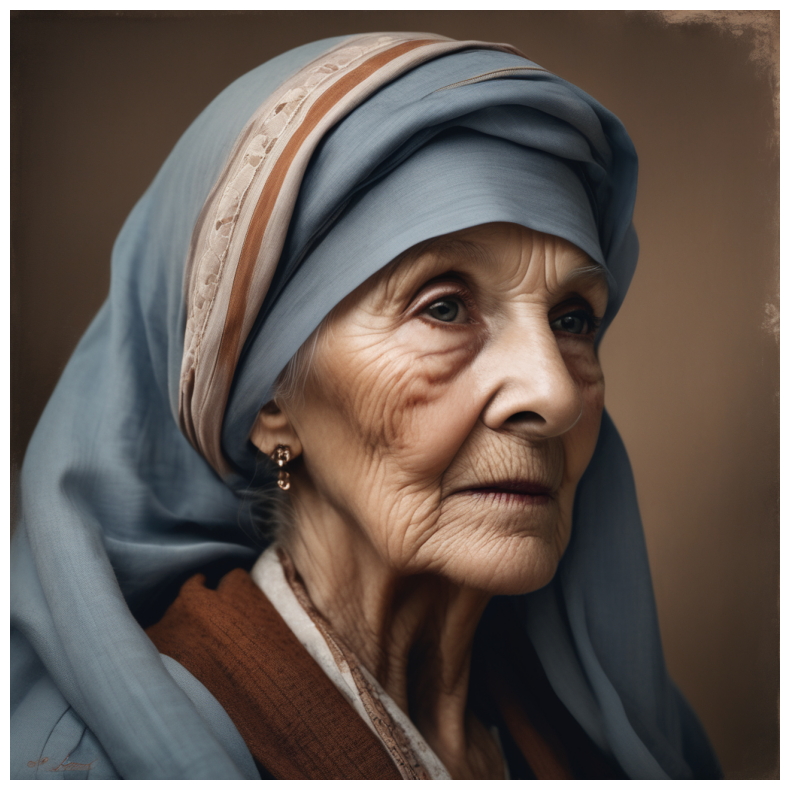

### Phase 2 Denoising ###


  0%|          | 0/50 [00:00<?, ?it/s]

### Phase 2 Decoding ###


  0%|          | 0/64 [00:00<?, ?it/s]

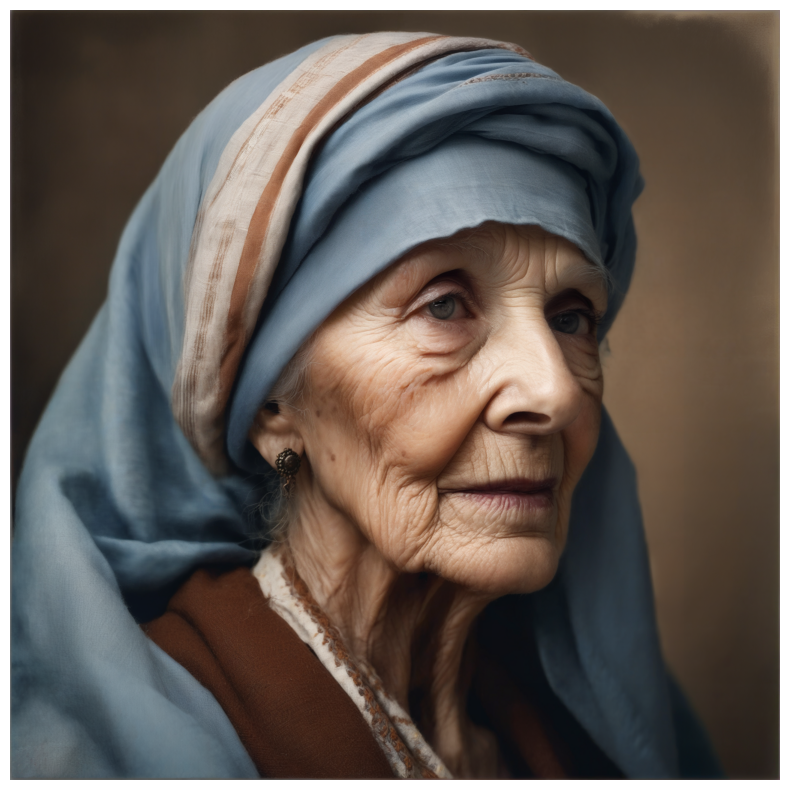

### Phase 3 Denoising ###


  0%|          | 0/50 [00:00<?, ?it/s]

### Phase 3 Decoding ###


  0%|          | 0/144 [00:00<?, ?it/s]

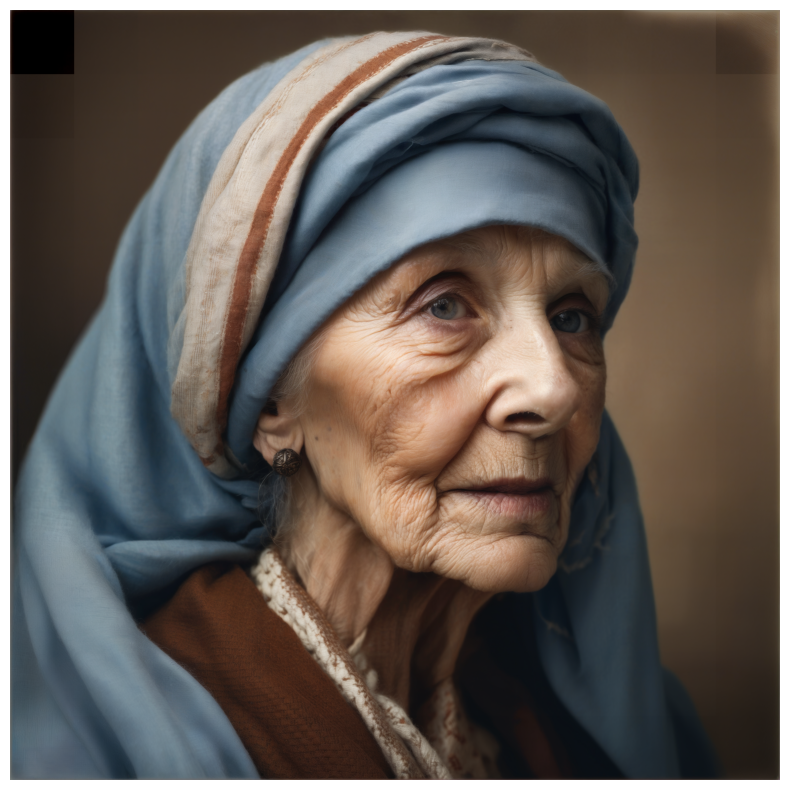

In [5]:
import os
import torch
from PIL import Image
import matplotlib.pyplot as plt
import accelerate

# see comment above! why this commented out
# from pipeline_demofusion_sdxl import DemoFusionSDXLPipeline


model_ckpt = "stabilityai/stable-diffusion-xl-base-1.0"
pipe = DemoFusionSDXLPipeline.from_pretrained(model_ckpt, torch_dtype=torch.float16)

pipe = pipe.to("cuda")

prompt = "Envision a portrait of an elderly woman, her face a canvas of time, framed by a headscarf with muted tones of rust and cream. Her eyes, blue like faded denim. Her attire, simple yet dignified."
negative_prompt = "blurry, ugly, duplicate, poorly drawn, deformed, mosaic"

generator = torch.Generator(device='cuda')
generator = generator.manual_seed(522)

# creates images in size 3072 x 3072 - cell outputs are only smaller previews!

images = pipe(prompt, negative_prompt=negative_prompt, generator=generator,
              height=3072, width=3072, view_batch_size=16, stride=64,
              num_inference_steps=50, guidance_scale = 7.5,
              cosine_scale_1=3, cosine_scale_2=1, cosine_scale_3=1, sigma=0.8,
              multi_decoder=True, show_image=True
             )

# Display and Save

In [7]:
def image_grid(imgs, save_path=None):

    w = 0
    for i, img in enumerate(imgs):
        h_, w_ = imgs[i].size
        w += w_
    h = h_
    grid = Image.new('RGB', size=(w, h))
    grid_w, grid_h = grid.size

    w = 0
    for i, img in enumerate(imgs):
        h_, w_ = imgs[i].size
        grid.paste(img, box=(w, h - h_))
        if save_path != None:
            img.save(save_path + "/img_{}.jpg".format((i + 1) * 1024))
        w += w_

    return grid

image_grid(images, save_path="./outputs/")